In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *

In [6]:
PATH = "../datasets/yeast_v4"
data_path = Path(PATH)

In [7]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [8]:
stats_name = "yeast_v4_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT


In [9]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [10]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmr1KO': 3}


In [11]:
x, y = next(iter(data.trn_dl))

In [12]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


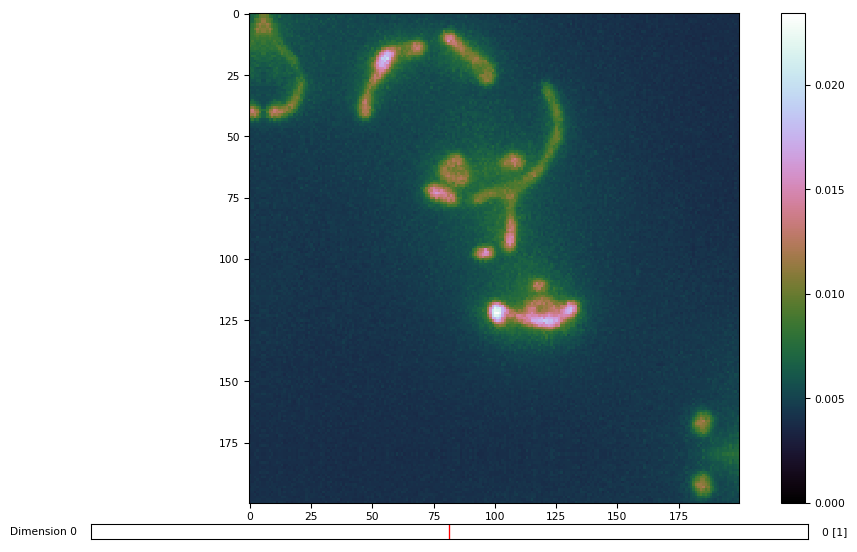

In [13]:
idx = 0
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx].item()).squeeze()[:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [11]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [12]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, NUM_CLASSES]), data) #(!) change channel-number & classes accordingly

In [13]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=80000, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=4, bias=True)
   )
 ), [3200000, 40, 160, 4])

In [14]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 80000]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 3200040)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 164)]))])

In [15]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

[0]:  20.0                                               
[1]: 76.92
[2]:   4.0
[3]: 4.167
epoch      trn_loss   val_loss   accuracy   
    0      1.420836   1.377092   0.266667  
[0]: 23.33                                               
[1]: 69.23
[2]:   4.0
[3]: 4.167
    1      1.415425   1.3762     0.257143  
[0]: 23.33                                               
[1]: 69.23
[2]:   4.0
[3]: 4.167
    2      1.41207    1.375266   0.257143  
[0]: 26.67                                               
[1]: 69.23
[2]:   4.0
[3]: 4.167
    3      1.409331   1.374028   0.266667  
[0]: 33.33                                                
[1]: 69.23
[2]:   4.0
[3]: 4.167
    4      1.407087   1.373138   0.285714  
  0%|          | 0/10 [00:00<?, ?it/s]

## ConvNet

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 4), data)

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
lr=1e-10

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [14]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [15]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [16]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [17]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), data)

In [18]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', tensor(510))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', tensor(3600))])),
            

In [19]:
wd=1e-5

In [20]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

[0]: 46.67%                                               
[1]:  0.0%
[2]:  0.0%
[3]: 70.83%
epoch      trn_loss   val_loss   accuracy   
    0      20.364245  27.687032  0.295238  
[0]:  0.0%                                                
[1]: 84.62%
[2]:  8.0%
[3]:  0.0%
    1      15.382025  4.333296   0.228571  
[0]: 90.0%                                                
[1]: 19.23%
[2]:  0.0%
[3]:  0.0%
    2      10.320631  2.943225   0.295238  
[0]: 10.0%                                                
[1]: 7.692%
[2]:  0.0%
[3]: 87.5%
    3      7.565112   2.558423   0.247619  
[0]: 96.67%                                              
[1]: 7.692%
[2]:  0.0%
[3]:  0.0%
    4      6.002826   2.966673   0.295238  
[0]: 56.67%                                               
[1]: 7.692%
[2]:  0.0%
[3]: 50.0%
    5      4.858822   1.702864   0.32381   
[0]: 73.33%                                               
[1]:  0.0%
[2]:  0.0%
[3]: 45.83%
    6      4.010649   1.392668   0.333333

[1.1821000757671538, 0.5047618990852719]

In [21]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

[0]: 53.33%                                                
[1]: 76.92%
[2]:  8.0%
[3]: 45.83%
epoch      trn_loss   val_loss   accuracy   
    0      0.8815     1.176579   0.52381   
[0]: 56.67%                                                
[1]: 57.69%
[2]:  4.0%
[3]: 62.5%
    1      0.883102   1.174602   0.504762  
[0]: 70.0%                                                 
[1]: 57.69%
[2]:  0.0%
[3]: 66.67%
    2      0.871939   1.28677    0.552381  
[0]: 56.67%                                                
[1]: 53.85%
[2]:  4.0%
[3]: 66.67%
    3      0.867274   1.160184   0.542857  
[0]: 43.33%                                                
[1]: 42.31%
[2]:  0.0%
[3]: 75.0%
    4      0.873903   1.274367   0.47619   
[0]: 66.67%                                                
[1]: 84.62%
[2]:  0.0%
[3]: 33.33%
    5      0.881124   1.309866   0.495238  
[0]: 60.0%                                                 
[1]: 80.77%
[2]:  4.0%
[3]: 50.0%
    6      0.863522   1.16993

[1.084251222156343, 0.5809523752757482]

In [22]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

[0]: 53.33%                                               
[1]: 84.62%
[2]: 24.0%
[3]: 58.33%
epoch      trn_loss   val_loss   accuracy   
    0      0.570005   0.962145   0.6       
[0]: 76.67%                                                
[1]: 76.92%
[2]:  8.0%
[3]: 54.17%
    1      0.568525   1.10823    0.542857  
[0]: 76.67%                                                
[1]: 73.08%
[2]: 20.0%
[3]: 70.83%
    2      0.597384   0.916262   0.657143  
[0]: 76.67%                                                
[1]: 73.08%
[2]: 24.0%
[3]: 66.67%
    3      0.611457   0.917159   0.638095  
[0]: 33.33%                                                
[1]: 50.0%
[2]:  4.0%
[3]: 95.83%
    4      0.622921   1.316939   0.571429  
[0]: 63.33%                                                
[1]: 92.31%
[2]: 12.0%
[3]: 66.67%
    5      0.631777   1.019933   0.609524  
[0]: 90.0%                                                 
[1]: 61.54%
[2]:  8.0%
[3]: 50.0%
    6      0.643922   1.19593

[0]: 60.0%                                                 
[1]: 61.54%
[2]: 28.0%
[3]: 75.0%
    59     0.485179   1.008708   0.638095  
[0]: 60.0%                                                
[1]: 69.23%
[2]: 12.0%
[3]: 62.5%
    60     0.489627   1.307249   0.590476  
[0]: 70.0%                                                 
[1]: 61.54%
[2]: 24.0%
[3]: 66.67%
    61     0.48467    1.037354   0.647619  
[0]: 80.0%                                                 
[1]: 73.08%
[2]: 56.0%
[3]: 37.5%
    62     0.47618    1.042691   0.638095  
[0]: 80.0%                                                 
[1]: 73.08%
[2]: 32.0%
[3]: 62.5%
    63     0.463121   1.027167   0.657143  
[0]: 86.67%                                                
[1]: 65.38%
[2]: 44.0%
[3]: 54.17%
    64     0.446624   0.989463   0.657143  
[0]: 90.0%                                                 
[1]: 61.54%
[2]: 28.0%
[3]: 70.83%
    65     0.426921   1.004144   0.657143  
[0]: 90.0%                      

[0]: 73.33%                                                
[1]: 57.69%
[2]: 36.0%
[3]: 66.67%
   118     0.202464   0.966357   0.647619  
[0]: 90.0%                                                
[1]: 65.38%
[2]: 32.0%
[3]: 54.17%
   119     0.190119   1.141513   0.647619  
[0]: 90.0%                                                 
[1]: 61.54%
[2]: 36.0%
[3]: 62.5%
   120     0.186105   1.055807   0.638095  
[0]: 86.67%                                                
[1]: 69.23%
[2]: 28.0%
[3]: 58.33%
   121     0.180975   1.089269   0.67619   
[0]: 93.33%                                                
[1]: 65.38%
[2]: 28.0%
[3]: 70.83%
   122     0.182063   1.334661   0.695238  
[0]: 76.67%                                                
[1]: 50.0%
[2]: 32.0%
[3]: 75.0%
   123     0.177827   1.015482   0.666667  
[0]: 93.33%                                                
[1]: 61.54%
[2]: 36.0%
[3]: 70.83%
   124     0.183849   1.047657   0.695238  
[0]: 90.0%                     

[0]: 93.33%                                               
[1]: 57.69%
[2]: 52.0%
[3]: 58.33%
   177     0.219734   1.164595   0.685714  
[0]: 80.0%                                                 
[1]: 73.08%
[2]: 64.0%
[3]: 54.17%
   178     0.200746   1.031812   0.714286  
[0]: 80.0%                                                
[1]: 65.38%
[2]: 56.0%
[3]: 50.0%
   179     0.199666   1.107808   0.685714  
[0]: 73.33%                                                
[1]: 46.15%
[2]: 68.0%
[3]: 45.83%
   180     0.207779   1.171765   0.666667  
[0]: 86.67%                                               
[1]: 50.0%
[2]: 72.0%
[3]: 54.17%
   181     0.210434   1.089094   0.685714  
[0]: 86.67%                                                
[1]: 69.23%
[2]: 44.0%
[3]: 50.0%
   182     0.210857   1.187507   0.666667  
[0]: 76.67%                                               
[1]: 69.23%
[2]: 24.0%
[3]: 83.33%
   183     0.199863   1.242207   0.67619   
[0]: 90.0%                        

KeyboardInterrupt: 

In [24]:
%time learn.fit(1e-1, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

[0]: 73.33%                                                 
[1]: 65.38%
[2]: 16.0%
[3]: 75.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.025886   1.586668   0.647619  
[0]: 100.0%                                                
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
    1      1.415857   16.293168  0.285714  
[0]:  0.0%                                                
[1]:  0.0%
[2]:  0.0%
[3]: 100.0%
    2      5.471524   16.890329  0.228571  
[0]: 13.33%                                               
[1]:  0.0%
[2]:  0.0%
[3]: 91.67%
    3      5.345148   3.629898   0.257143  
[0]:  0.0%                                                
[1]: 100.0%
[2]:  0.0%
[3]:  0.0%
    4      4.41441    2.000175   0.247619  
[0]: 20.0%                                                
[1]: 92.31%
[2]:  0.0%
[3]: 8.333%
    5      3.643529   1.386253   0.314286  
[0]: 50.0%                                                
[1]: 53.85%
[2]:  0.0%
[3]: 41.67%
    6      3.054517   1.47857    0.4

[0]: 93.33%                                                
[1]: 61.54%
[2]: 36.0%
[3]: 29.17%
    59     0.63346    1.172427   0.609524  
[0]: 96.67%                                                
[1]: 50.0%
[2]: 12.0%
[3]: 37.5%
    60     0.634343   1.288552   0.561905  
[0]: 83.33%                                                
[1]: 76.92%
[2]: 12.0%
[3]: 50.0%
    61     0.632028   1.195417   0.619048  
[0]: 76.67%                                                
[1]: 96.15%
[2]: 36.0%
[3]: 37.5%
    62     0.621277   1.037583   0.619048  
[0]: 90.0%                                                 
[1]: 61.54%
[2]: 24.0%
[3]: 58.33%
    63     0.6337     1.009908   0.647619  
[0]: 83.33%                                                
[1]: 50.0%
[2]: 20.0%
[3]: 79.17%
    64     0.616252   0.940867   0.638095  
[0]: 90.0%                                                 
[1]: 53.85%
[2]: 12.0%
[3]: 75.0%
    65     0.614493   0.999711   0.628571  
[0]: 90.0%                       

[0]: 80.0%                                                 
[1]: 65.38%
[2]: 44.0%
[3]: 66.67%
   118     0.326144   0.783311   0.72381   
[0]: 80.0%                                                 
[1]: 69.23%
[2]: 44.0%
[3]: 66.67%
   119     0.314026   0.771999   0.72381   
[0]: 80.0%                                                 
[1]: 76.92%
[2]: 48.0%
[3]: 62.5%
   120     0.301336   0.758021   0.752381  
[0]: 76.67%                                                
[1]: 76.92%
[2]: 56.0%
[3]: 62.5%
   121     0.297094   0.723318   0.733333  
[0]: 96.67%                                                
[1]: 80.77%
[2]: 20.0%
[3]: 58.33%
   122     0.306014   1.235276   0.695238  
[0]: 90.0%                                                 
[1]: 69.23%
[2]: 40.0%
[3]: 66.67%
   123     0.307851   1.003243   0.733333  
[0]: 83.33%                                                
[1]: 69.23%
[2]: 40.0%
[3]: 79.17%
   124     0.307734   0.91784    0.72381   
[0]: 96.67%                  

[0]: 90.0%                                                 
[1]: 76.92%
[2]: 48.0%
[3]: 62.5%
   177     0.363892   0.903516   0.733333  
[0]: 93.33%                                               
[1]: 76.92%
[2]: 28.0%
[3]: 45.83%
   178     0.350034   1.404062   0.666667  
[0]: 83.33%                                                
[1]: 88.46%
[2]: 48.0%
[3]: 58.33%
   179     0.338164   1.134469   0.714286  
[0]: 83.33%                                                
[1]: 88.46%
[2]: 24.0%
[3]: 75.0%
   180     0.319296   1.164174   0.666667  
[0]: 93.33%                                                
[1]: 76.92%
[2]: 44.0%
[3]: 58.33%
   181     0.305804   1.080373   0.704762  
[0]: 93.33%                                                
[1]: 46.15%
[2]: 40.0%
[3]: 58.33%
   182     0.297518   1.183819   0.666667  
[0]: 70.0%                                                 
[1]: 69.23%
[2]: 44.0%
[3]: 87.5%
   183     0.293326   0.86857    0.742857  
[0]: 90.0%                     

[0]: 86.67%                                               
[1]: 61.54%
[2]: 32.0%
[3]: 83.33%
   236     0.140118   1.193404   0.752381  
[0]: 86.67%                                                
[1]: 61.54%
[2]: 28.0%
[3]: 87.5%
   237     0.129153   1.239544   0.752381  
[0]: 90.0%                                                 
[1]: 76.92%
[2]: 40.0%
[3]: 79.17%
   238     0.117216   1.122697   0.761905  
[0]: 86.67%                                                
[1]: 57.69%
[2]: 32.0%
[3]: 87.5%
   239     0.107733   1.110943   0.752381  
[0]: 90.0%                                                  
[1]: 69.23%
[2]: 36.0%
[3]: 75.0%
   240     0.098832   1.154428   0.72381   
[0]: 83.33%                                                 
[1]: 65.38%
[2]: 44.0%
[3]: 79.17%
   241     0.090281   0.974588   0.733333  
[0]: 90.0%                                                  
[1]: 50.0%
[2]: 32.0%
[3]: 87.5%
   242     0.087236   1.316897   0.714286  
[0]: 93.33%                   

[0]: 90.0%                                                
[1]: 73.08%
[2]: 48.0%
[3]: 62.5%
   295     0.190134   1.303462   0.714286  
[0]: 83.33%                                                
[1]: 61.54%
[2]: 40.0%
[3]: 79.17%
   296     0.1854     1.179717   0.72381   
[0]: 86.67%                                                
[1]: 80.77%
[2]: 52.0%
[3]: 70.83%
   297     0.16843    1.264625   0.780952  
[0]: 90.0%                                                 
[1]: 73.08%
[2]: 60.0%
[3]: 75.0%
   298     0.157104   1.136226   0.771429  
[0]: 86.67%                                                
[1]: 69.23%
[2]: 40.0%
[3]: 62.5%
   299     0.145958   1.487104   0.714286  
[0]: 80.0%                                                 
[1]: 80.77%
[2]: 64.0%
[3]: 45.83%
   300     0.149281   1.321715   0.742857  
[0]: 80.0%                                                 
[1]: 65.38%
[2]: 60.0%
[3]: 75.0%
   301     0.157699   1.288812   0.771429  
[0]: 76.67%                     

[1.3729788042250133, 0.7333333350363231]

In [25]:
learn.save('Objective_A_ResNets')

In [26]:
log_preds, y = learn.TTA()

In [28]:
y.shape

(105,)

In [36]:
log_preds[0].shape

(105, 4)

In [56]:
preds = np.argmax(log_preds[0],axis=1)
probs = np.exp(log_preds[:,1])

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[23  4  0  3]
 [ 2 22  1  1]
 [ 3  3 13  6]
 [ 1  3  1 19]]


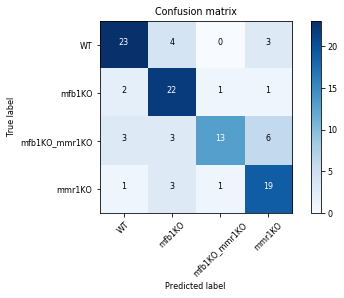

In [58]:
plot_confusion_matrix(cm, data.classes)